Checking to see how much faster things might be if we have the data stored locally, vs doing all the data processing/loading on the each request for a new batch

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import h5py
from exabiome.nn.loader import read_dataset, LazySeqDataset
import argparse
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from model import *
from data import *
from fastai.text.all import *

In [2]:
x_df = pd.read_csv('data/toy_x.csv')

In [3]:
x_df.shape

(19010, 4097)

In [4]:
y_df = pd.read_csv('data/toy_y.csv')
y_df.shape

(19010, 2)

In [5]:
x_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,1.0,1.0,9.0,9.0,10.0,0.0,1.0,10.0,10.0,...,0.0,1.0,9.0,10.0,1.0,10.0,0.0,0.0,1.0,1.0
1,1,10.0,1.0,10.0,1.0,1.0,0.0,9.0,0.0,9.0,...,9.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,9.0
2,2,10.0,10.0,10.0,10.0,9.0,1.0,10.0,9.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,9.0,9.0,9.0,9.0,0.0,0.0,9.0,0.0,...,9.0,10.0,9.0,0.0,0.0,9.0,0.0,1.0,10.0,0.0
4,4,1.0,0.0,1.0,0.0,10.0,1.0,10.0,10.0,9.0,...,0.0,0.0,9.0,9.0,10.0,0.0,9.0,0.0,9.0,9.0


In [6]:
torch.Tensor(x_df.iloc[0][1:]).shape

torch.Size([4096])

In [7]:
torch.Tensor(y_df.iloc[0][1:])

tensor([15.])

In [8]:
len(x_df)

19010

In [9]:
class local_ds(Dataset):
    def __init__(self, xs_df, ys_df):
        self.xs = xs_df
        self.ys = ys_df
    
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        x = torch.Tensor(self.xs.iloc[idx][1:])
        y = torch.Tensor(self.ys.iloc[idx][1:])
        x = x.to(torch.float)
        y = y.to(torch.long)
        return (x.unsqueeze(0), y.squeeze())

In [10]:
train_ds = local_ds(x_df[:len(x_df)-2000], y_df[:len(x_df)-2000])
val_ds = local_ds(x_df[-2000:], y_df[-2000:])

In [11]:
len(train_ds), len(val_ds)

(17010, 2000)

In [12]:
train_ds[0]

(tensor([[1., 1., 9.,  ..., 0., 1., 1.]]), tensor(15))

In [13]:
train_ds[0][1].shape

torch.Size([])

In [14]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_dl = DataLoader(val_ds, batch_size=128, shuffle=False)
len(train_dl), len(valid_dl)

(133, 16)

In [15]:
dls = DataLoaders(train_dl, valid_dl)

In [16]:
class compress_cb(Callback):
    def after_pred(self):
        self.learn.pred = self.pred.squeeze(2)

In [17]:
model = EffNet_b0(out_feats=1)

In [18]:
model.to('cuda')
dls.to('cuda')

In [19]:
batch = next(iter(dls.train))
batch[0].shape, batch[1].shape

(torch.Size([128, 1, 4096]), torch.Size([128]))

In [20]:
out = model(batch[0])
out.shape

torch.Size([128, 18, 1])

In [21]:
nn.CrossEntropyLoss()(out.squeeze(2), batch[1])

tensor(3.0587, device='cuda:0', grad_fn=<NllLossBackward>)

In [23]:
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(),
               cbs=[compress_cb], 
                metrics=[accuracy]).to_fp16()

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.17378008365631104)

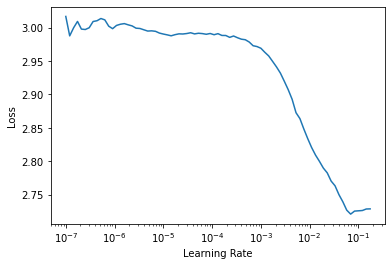

In [24]:
learn.lr_find()

In [25]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,time
0,2.277473,2.597465,0.100000,01:09


epoch,train_loss,valid_loss,accuracy,time
0,1.923933,1.732391,0.212500,01:08
1,1.597517,1.467500,0.455500,01:08


This looks 3 times faster when pulling the data from a csv -- probably the way to go for prototyping. Should look into how fast it is with the data in the /tmp folder as per this: https://docs-dev.nersc.gov/cgpu/usage/